# Import Necessary Libraries

In [24]:
from dataclasses import dataclass
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import classification_report, accuracy_score
import torch
import numpy as np
import h5py
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import random
import tqdm
from plotly import graph_objects as go
import plotly.express as px
from plotly.offline import init_notebook_mode

# Initialize Plotly for Jupyter
init_notebook_mode(connected=True)

# Baseline Model: Linear Discriminant Analysis (LDA)

# Load-in Dataset

In [25]:
### Load the dataset ###
@dataclass
# dataclass annotations create structured, immutable configurations
# specifies file paths for data
class path_config:
    data = '../input/3d-mnist'
    full_vectors = os.path.join(data, 'full_dataset_vectors.h5')
    
with h5py.File(path_config.full_vectors, "r") as hf:
    X_train = hf["X_train"][:]
    y_train = hf["y_train"][:]
    X_test = hf["X_test"][:]
    y_test = hf["y_test"][:]

print("X and y dataset dimensions:")
print("X_train ", X_train.shape)
print("y_train ", y_train.shape)
print("\nX_test_", X_test.shape)
print("y_test", y_test.shape)

X and y dataset dimensions:
X_train  (10000, 4096)
y_train  (10000,)

X_test_ (2000, 4096)
y_test (2000,)


In [26]:
### Train an LDA model ###
lda = LinearDiscriminantAnalysis()
lda.fit(X_train, y_train)

### Evaluate the model on the test set ###
y_pred = lda.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

### Print metrics ###
print(f"\nLDA Baseline Model Accuracy: {accuracy * 100:.2f}%")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))


LDA Baseline Model Accuracy: 51.05%

Classification Report:
              precision    recall  f1-score   support

           0       0.56      0.62      0.59       170
           1       0.70      0.67      0.68       252
           2       0.50      0.44      0.47       232
           3       0.47      0.43      0.45       214
           4       0.54      0.47      0.50       220
           5       0.48      0.45      0.47       174
           6       0.44      0.52      0.47       174
           7       0.54      0.51      0.52       198
           8       0.40      0.46      0.43       178
           9       0.45      0.52      0.48       188

    accuracy                           0.51      2000
   macro avg       0.51      0.51      0.51      2000
weighted avg       0.51      0.51      0.51      2000



# Better Fit Model: Convolutional Neural Network (CNN)

# Load-in Dataset

In [41]:
@dataclass
# dataclass annotations create structured, immutable configurations
# specifies file paths for data
class path_config:
    data = '../input/3d-mnist'
    full_vectors = os.path.join(data, 'full_dataset_vectors.h5')
    
with h5py.File(path_config.full_vectors, "r") as hf:
    X_train = hf["X_train"][:]
    y_train = hf["y_train"][:]
    X_test = hf["X_test"][:]
    y_test = hf["y_test"][:]

# Set-up Immutable Configurations for CNN

In [42]:
# --- CONFIGURATION ---
#### consolidate into just class Config:
@dataclass
class Config:
    # dataset file path config
    data = '../input/3d-mnist'
    full_vectors = os.path.join(data, 'full_dataset_vectors.h5')
    test_point_clouds = os.path.join(data, 'test_point_clouds.h5')
    train_point_clouds = os.path.join(data, 'train_point_clouds.h5')

    # data config
    threshold = 0.2
    upper = 1
    lower = 0
    x_shape = 16
    y_shape = 16
    z_shape = 16

    # training cofig
    lr = 0.001
    epochs = 30
    batch_size = 32
    num_workers = 2
    weight_decay = 0.0001

# Helper Functions

In [43]:
# -------------------- Helper Functions --------------------
def create_tensor(tensor, config: Config, threshold=False):
    if threshold:
        tensor = np.where(tensor > config.threshold, config.lower, config.upper)
    tensor = tensor.reshape((tensor.shape[0], config.y_shape, config.x_shape, config.z_shape))
    return tensor

def one_hot_encode(y_train, y_test):
    encoder = OneHotEncoder(sparse_output=False)
    y_train = encoder.fit_transform(y_train.reshape((-1, 1)))
    y_test = encoder.transform(y_test.reshape((-1, 1)))
    return y_train, y_test

## EXECUTION
config = Config()

X_train_tensor, X_test_tensor = create_tensor(X_train, config), create_tensor(X_test, config)
y_train_encoded, y_test_encoded = one_hot_encode(y_train, y_test)

print("X and y dataset dimensions:")
print("X_train ", X_train.shape)
print("X_train_tensor ", X_train_tensor.shape)
print("y_train ", y_train.shape)
print("y_train_encoded ", y_train.shape)
print("\nX_test_", X_test.shape)
print("X_test_tensor", X_test_tensor.shape)
print("y_test", y_test.shape)
print("y_test_encoded", y_test.shape)

X and y dataset dimensions:
X_train  (10000, 4096)
X_train_tensor  (10000, 16, 16, 16)
y_train  (10000,)
y_train_encoded  (10000,)

X_test_ (2000, 4096)
X_test_tensor (2000, 16, 16, 16)
y_test (2000,)
y_test_encoded (2000,)


# Data Visualization Functions

In [44]:
# --- DATA VISUALIZATION ---
def visualize_labels(y_train):
    # Get unique labels and their counts
    labels, counts = np.unique(y_train, return_counts=True)
    
    # Calculate percentages
    percentages = (counts / counts.sum()) * 100

    # Create a bar plot
    colors = sns.color_palette("flare", len(labels))
    plt.figure(figsize=(10, 6))
    plt.title('Label Distribution')
    bars = plt.bar(labels, counts, color=colors, edgecolor='k')
    plt.xlabel('Labels')
    plt.ylabel('Counts')
    plt.xticks(labels)  # Ensure labels match the unique values in y_train
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    
    # Add percentages above each bar
    for bar, percentage in zip(bars, percentages):
        plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), f'{percentage:.1f}%', 
                 ha='center', va='bottom', fontsize=10, color='black')
    plt.show()

def visualize_slice(X_train, y_train, image_index=2):
    square_root = int(X_train.shape[-1] ** 0.5)
    plt.figure(figsize=(16, 16))
    plt.suptitle(f'Label: {y_train[image_index].argmax()}')
    for index in range(X_train.shape[-1]):
        plt.subplot(square_root, square_root, index + 1)
        plt.axis('off')
        plt.imshow(X_train[image_index, :, :, index])
    plt.show()

def visualize_voxels(X, y):
    for _ in range(3):
        idx = random.randint(0, len(X)-1)
        voxels = X[idx]
        label = np.argmax(y[idx])
        coords = np.argwhere(voxels > 0)
        values = (voxels[coords[:, 0], coords[:, 1], coords[:, 2]] * 255).astype(int)

        fig = go.Figure(data=[
            go.Scatter3d(
                x=coords[:, 0], y=coords[:, 1], z=coords[:, 2],
                mode='markers',
                marker=dict(
                    size=6,
                    color=values,
                    colorscale='Viridis',
                    opacity=0.8
                ),
                text=f"Label: {label}"
            )
        ])
        fig.show()


# Visualization of Training Dataset

Visualization of Training Dataset


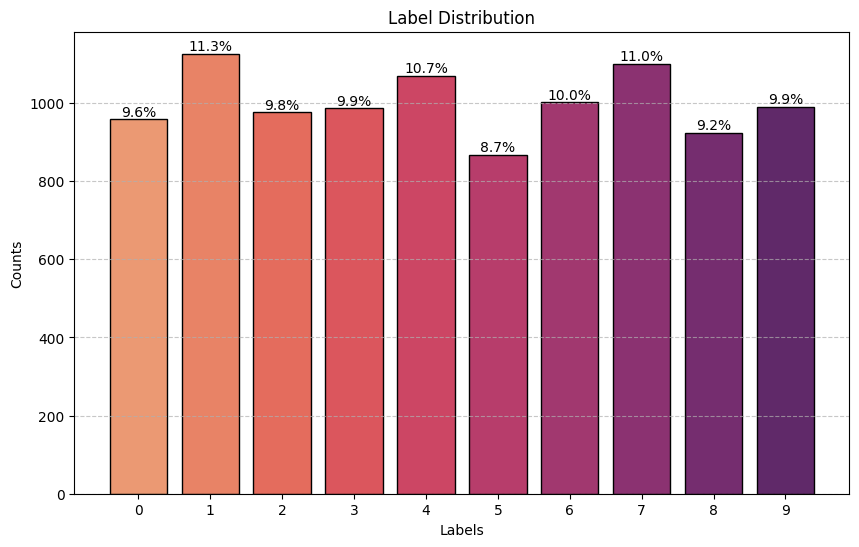

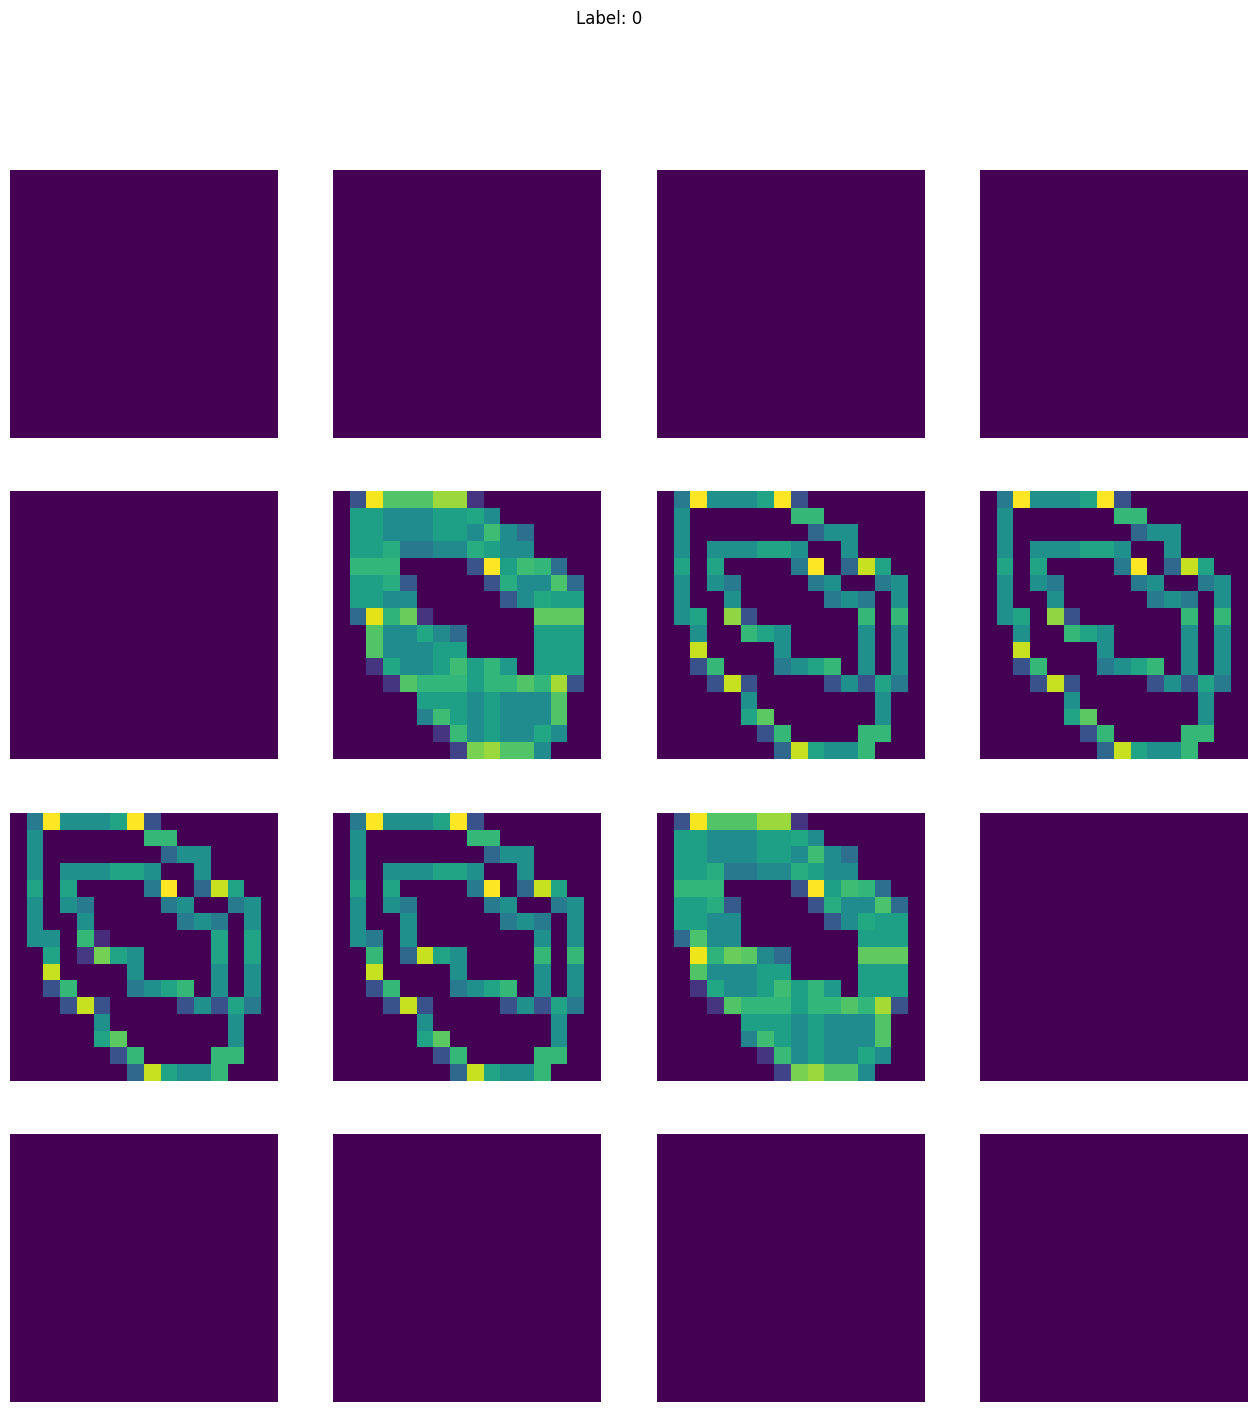

In [45]:
## EXECUTION
    
print("Visualization of Training Dataset")
visualize_labels(y_train)
visualize_slice(X_train_tensor, y_train)
visualize_voxels(X_train_tensor, y_train)

# Visualization of Test Dataset

Visualization of Test Dataset


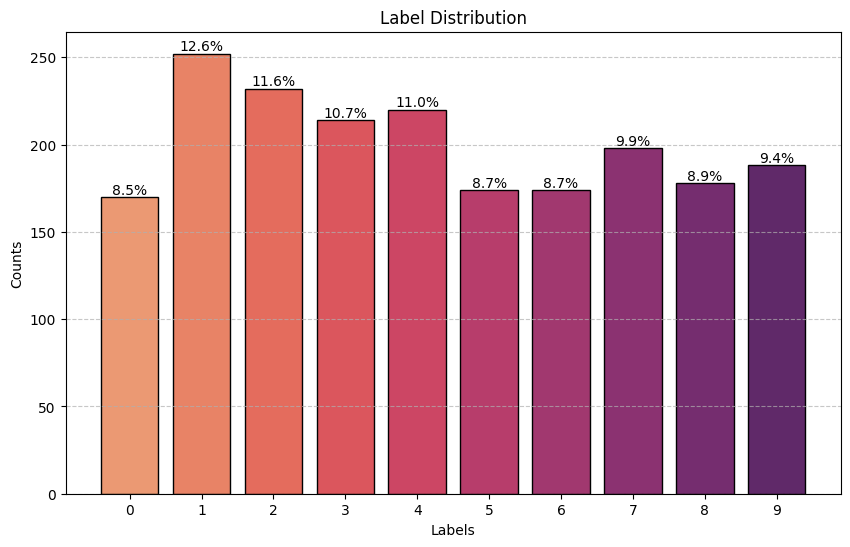

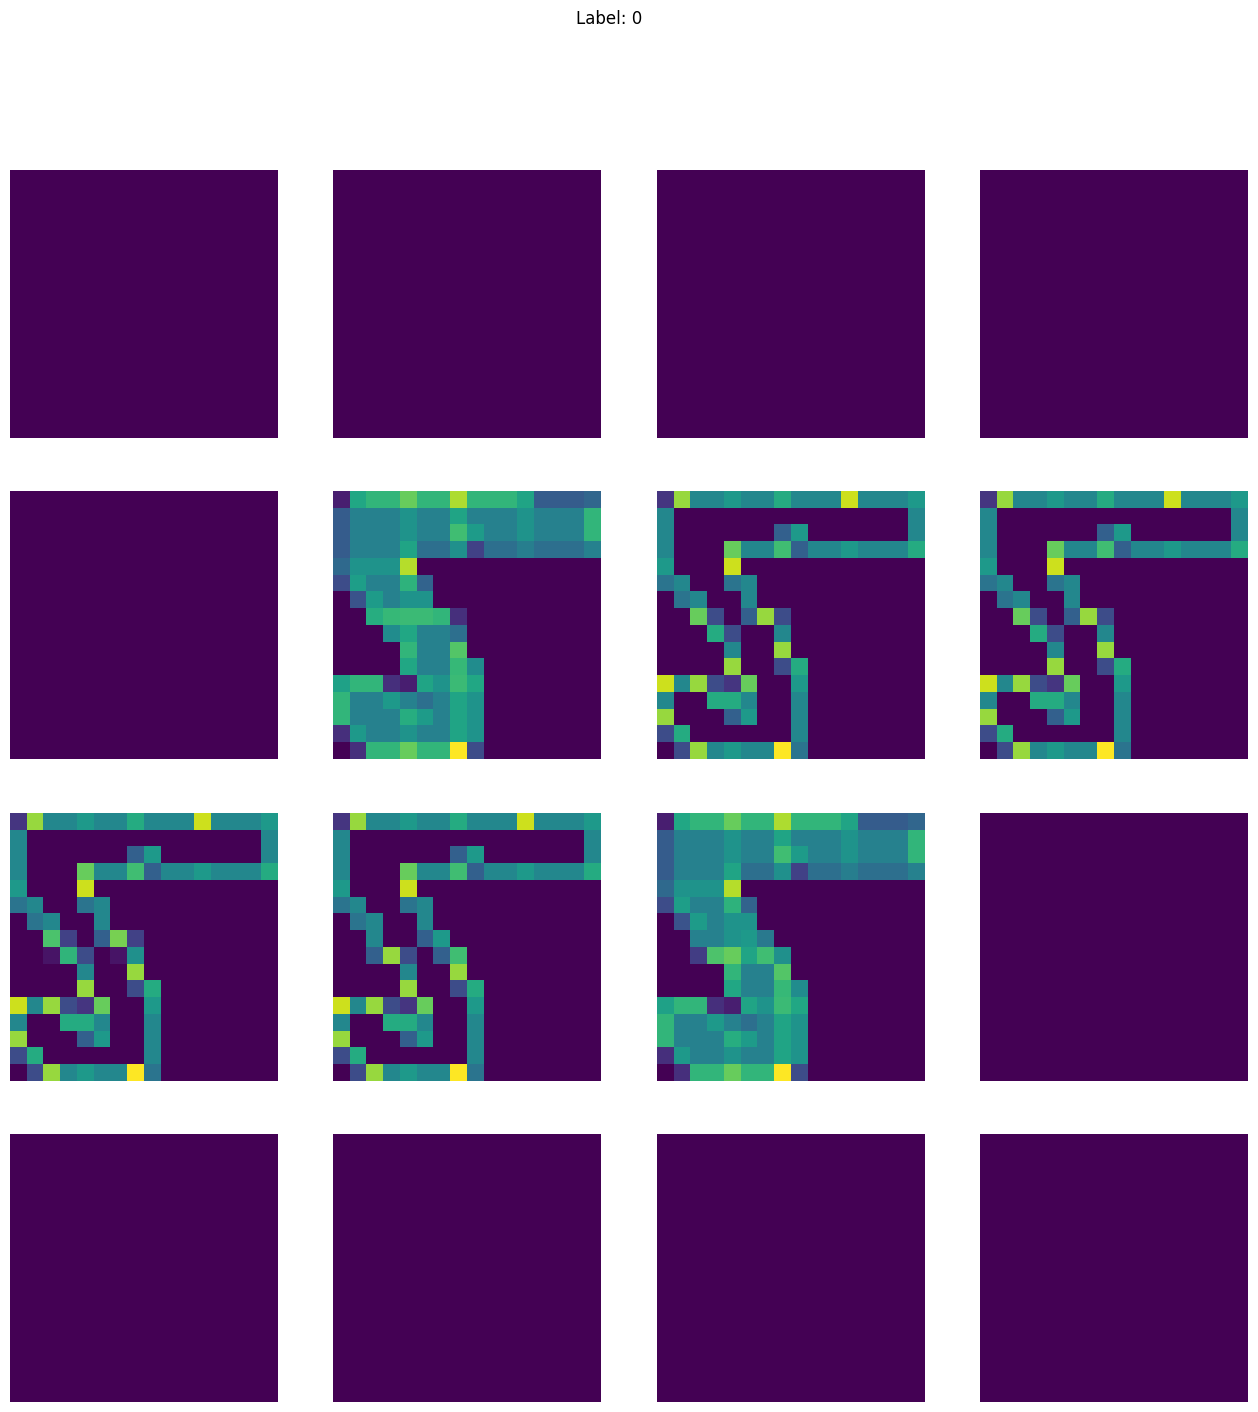

In [46]:
## EXECUTION
print("Visualization of Test Dataset")
visualize_labels(y_test)
visualize_slice(X_test_tensor, y_test)
visualize_voxels(X_test_tensor, y_test)

# CNN Model Layers

In [47]:
# --- DATASET CLASS ---
class Dataset(torch.utils.data.Dataset):
    """
    A custom Dataset class to handle data points and their labels for PyTorch models.
    """
    def __init__(self, points, labels):
        """
        Initializes the dataset with points and labels.
        Args:
            points (numpy.ndarray): The input data points.
            labels (numpy.ndarray): The corresponding labels.
        """
        super(Dataset, self).__init__()
        self.points = points
        self.labels = labels

    def __getitem__(self, index):
        """
        Fetches a single data point and its label at the specified index.
        Args:
            index (int): The index of the data point to retrieve.
        Returns:
            (torch.Tensor, torch.Tensor): A tuple of the data point and its label.
        """
        # Convert the data point to a PyTorch tensor and add a channel dimension
        points = torch.from_numpy(np.expand_dims(self.points[index], axis=0)).float()
        # Convert the label to a PyTorch tensor
        labels = torch.from_numpy(self.labels[index]).float()
        return points, labels

    def __len__(self):
        """
        Returns the total number of samples in the dataset.
        """
        return len(self.labels)

# --- MODEL DEFINITION ---
class Conv3DBN(torch.nn.Module):
    """
    A 3D convolutional layer followed by batch normalization and a ReLU activation.
    """
    def __init__(self, in_features, out_features):
        """
        Initializes the Conv3DBN layer.
        Args:
            in_features (int): Number of input channels.
            out_features (int): Number of output channels.
        """
        super(Conv3DBN, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv3d(in_features, out_features, kernel_size=(3, 3, 3)),  # 3D convolution
            torch.nn.BatchNorm3d(out_features),  # Batch normalization for stability
            torch.nn.ReLU()  # ReLU activation for non-linearity
        )

    def forward(self, x):
        """
        Forward pass through the Conv3DBN layer.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor.
        """
        return self.layers(x)

class Conv3DMaxPool(torch.nn.Module):
    """
    A 3D convolutional layer followed by a 3D max-pooling operation.
    """
    def __init__(self, in_features, out_features):
        """
        Initializes the Conv3DMaxPool layer.
        Args:
            in_features (int): Number of input channels.
            out_features (int): Number of output channels.
        """
        super(Conv3DMaxPool, self).__init__()
        self.layers = torch.nn.Sequential(
            torch.nn.Conv3d(in_features, out_features, kernel_size=(3, 3, 3)),  # 3D convolution
            torch.nn.MaxPool3d((2, 2, 2))  # Downsampling using max pooling
        )

    def forward(self, x):
        """
        Forward pass through the Conv3DMaxPool layer.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor.
        """
        return self.layers(x)

class Model(torch.nn.Module):
    """
    The main model consisting of multiple 3D convolutional layers, followed by a fully connected layer.
    """
    def __init__(self):
        """
        Initializes the model with a series of convolutional layers and a fully connected layer.
        """
        super(Model, self).__init__()
        self.cnns = torch.nn.Sequential(
            Conv3DBN(1, 32),  # 3D convolutional block with 32 filters
            Conv3DBN(32, 64),  # 3D convolutional block with 64 filters
            Conv3DMaxPool(64, 64),  # 3D convolutional block with max-pooling
            Conv3DBN(64, 64),  # Additional 3D convolutional block
            Conv3DBN(64, 16)  # Final 3D convolutional block reducing channels to 16
        )
        self.flatten = torch.nn.Flatten()  # Flattens the tensor for the fully connected layer
        self.dropout = torch.nn.Dropout(0.2)  # Dropout for regularization
        self.linear = torch.nn.Linear(16, 10)  # Fully connected layer for classification

    def forward(self, x):
        """
        Forward pass through the model.
        Args:
            x (torch.Tensor): Input tensor.
        Returns:
            torch.Tensor: Output tensor (class scores).
        """
        x = self.cnns(x)  # Pass input through the convolutional layers
        x = self.flatten(x)  # Flatten the output
        x = self.dropout(x)  # Apply dropout
        return self.linear(x)  # Pass through the fully connected layer


# Use CNN Model to Train and Test on Dataset

In [49]:
# --- TRAINER CLASS ---
class Trainer:
    """
    A class for training and evaluating a convolutional neural network model.

    Attributes:
        train_dataloader (torch.utils.data.DataLoader): DataLoader for training data.
        test_dataloader (torch.utils.data.DataLoader): DataLoader for testing data.
        model (torch.nn.Module): The neural network model to train and evaluate.
        device (torch.device): The device on which computations are performed (CPU or GPU).
        loss_fn (torch.nn.Module): The loss function for training (CrossEntropyLoss).
        optimizer (torch.optim.Optimizer): The optimizer for training (Adam).
        epochs (int): Number of epochs for training.
        history (dict): Dictionary to track training and testing accuracy and loss over epochs.
    """

    def __init__(self, train_points, train_labels, test_points, test_labels, config: Config):
        """
        Initializes the Trainer class.

        Args:
            train_points (np.ndarray): Training data points.
            train_labels (np.ndarray): Labels corresponding to the training data.
            test_points (np.ndarray): Testing data points.
            test_labels (np.ndarray): Labels corresponding to the testing data.
            config (Config): Configuration object containing hyperparameters like batch_size, 
                             learning_rate (lr), weight_decay, and number of epochs.
        """
        self.train_dataloader = torch.utils.data.DataLoader(
            Dataset(train_points, train_labels), batch_size=config.batch_size, num_workers=config.num_workers)
        self.test_dataloader = torch.utils.data.DataLoader(
            Dataset(test_points, test_labels), batch_size=config.batch_size, num_workers=config.num_workers)
        
        self.model = Model()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.loss_fn = torch.nn.CrossEntropyLoss()
        self.optimizer = torch.optim.Adam(self.model.parameters(), lr=config.lr, weight_decay=config.weight_decay)
        self.epochs = config.epochs
        self.history = {"train_accuracy": [], "train_loss": [], "test_accuracy": [], "test_loss": []}
        self.model.to(self.device)

    def train_epoch(self):
        """
        Trains the model for one epoch.

        Returns:
            Tuple[float, float]: Average training loss and accuracy for the epoch.
        """
        self.model.train()
        running_loss, running_accuracy = 0, 0
        for points, labels in tqdm.tqdm(self.train_dataloader, desc="Training"):
            points, labels = points.to(self.device), labels.to(self.device)
            self.optimizer.zero_grad()
            outputs = self.model(points)
            loss = self.loss_fn(outputs, labels)
            loss.backward()
            self.optimizer.step()

            preds = torch.argmax(outputs, dim=1)
            targets = torch.argmax(labels, dim=1)
            running_loss += loss.item()
            running_accuracy += accuracy_score(targets.cpu(), preds.cpu())
        
        return running_loss / len(self.train_dataloader), running_accuracy / len(self.train_dataloader)

    def test_epoch(self):
        """
        Evaluates the model on the test dataset for one epoch.

        Returns:
            Tuple[float, float, list, list]: Average test loss, test accuracy, 
                                             predictions, and true labels.
        """
        self.model.eval()
        running_loss, running_accuracy = 0, 0
        all_preds, all_targets = [], []
        with torch.no_grad():
            for points, labels in tqdm.tqdm(self.test_dataloader, desc="Evaluating"):
                points, labels = points.to(self.device), labels.to(self.device)
                outputs = self.model(points)
                loss = self.loss_fn(outputs, labels)
                running_loss += loss.item()

                preds = torch.argmax(outputs, dim=1)
                targets = torch.argmax(labels, dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_targets.extend(targets.cpu().numpy())
                running_accuracy += accuracy_score(targets.cpu(), preds.cpu())
        
        return running_loss / len(self.test_dataloader), running_accuracy / len(self.test_dataloader), all_preds, all_targets

    def train_and_fit(self):
        """
        Trains the model for the specified number of epochs and evaluates it.

        Tracks training and testing accuracy and loss for each epoch.

        Returns:
            list: Predictions for the test dataset after training.
        """
        for epoch in range(self.epochs):
            print(f"Epoch {epoch+1}/{self.epochs}:")
            train_loss, train_accuracy = self.train_epoch()
            test_loss, test_accuracy, preds, targets = self.test_epoch()
            
            self.history["train_loss"].append(train_loss)
            self.history["train_accuracy"].append(train_accuracy)
            self.history["test_loss"].append(test_loss)
            self.history["test_accuracy"].append(test_accuracy)
            
            print(f"  Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}")
            print(f"  Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        accuracy = accuracy_score(targets, preds)
        print(f"\n\nCNN Model Accuracy: {accuracy * 100:.2f}%")
        print("Classification Report:")
        print(classification_report(targets, preds, digits=4))

        return preds
    

## EXECUTION
trainer = Trainer(X_train_tensor, y_train_encoded, X_test_tensor, y_test_encoded, Config)
predictions = trainer.train_and_fit()

Epoch 1/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 127.43it/s]


  Train Loss: 1.6150, Train Accuracy: 0.4965
  Test Loss: 1.3005, Test Accuracy: 0.5789
Epoch 2/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 133.13it/s]


  Train Loss: 1.2432, Train Accuracy: 0.5965
  Test Loss: 1.0225, Test Accuracy: 0.6632
Epoch 3/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 131.49it/s]


  Train Loss: 1.0975, Train Accuracy: 0.6322
  Test Loss: 0.9358, Test Accuracy: 0.6895
Epoch 4/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 130.43it/s]


  Train Loss: 0.9741, Train Accuracy: 0.6743
  Test Loss: 0.9282, Test Accuracy: 0.6845
Epoch 5/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 119.20it/s]


  Train Loss: 0.8825, Train Accuracy: 0.7060
  Test Loss: 0.8848, Test Accuracy: 0.7029
Epoch 6/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 127.34it/s]


  Train Loss: 0.7838, Train Accuracy: 0.7371
  Test Loss: 1.0888, Test Accuracy: 0.6677
Epoch 7/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 130.81it/s]


  Train Loss: 0.6762, Train Accuracy: 0.7708
  Test Loss: 0.9315, Test Accuracy: 0.7029
Epoch 8/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 132.72it/s]


  Train Loss: 0.5907, Train Accuracy: 0.8029
  Test Loss: 0.9827, Test Accuracy: 0.7029
Epoch 9/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 131.43it/s]


  Train Loss: 0.5268, Train Accuracy: 0.8231
  Test Loss: 1.0365, Test Accuracy: 0.6875
Epoch 10/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 130.73it/s]


  Train Loss: 0.4451, Train Accuracy: 0.8490
  Test Loss: 0.9598, Test Accuracy: 0.7207
Epoch 11/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 132.41it/s]


  Train Loss: 0.3919, Train Accuracy: 0.8660
  Test Loss: 0.9580, Test Accuracy: 0.7242
Epoch 12/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 131.46it/s]


  Train Loss: 0.3259, Train Accuracy: 0.8894
  Test Loss: 1.0616, Test Accuracy: 0.7118
Epoch 13/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 132.10it/s]


  Train Loss: 0.3045, Train Accuracy: 0.8964
  Test Loss: 1.0794, Test Accuracy: 0.7202
Epoch 14/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 129.39it/s]


  Train Loss: 0.2705, Train Accuracy: 0.9065
  Test Loss: 1.1217, Test Accuracy: 0.7113
Epoch 15/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 133.02it/s]


  Train Loss: 0.2473, Train Accuracy: 0.9170
  Test Loss: 1.1337, Test Accuracy: 0.7103
Epoch 16/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 128.72it/s]


  Train Loss: 0.2291, Train Accuracy: 0.9220
  Test Loss: 1.1491, Test Accuracy: 0.7168
Epoch 17/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 130.05it/s]


  Train Loss: 0.2050, Train Accuracy: 0.9312
  Test Loss: 1.2161, Test Accuracy: 0.7163
Epoch 18/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 134.58it/s]


  Train Loss: 0.1919, Train Accuracy: 0.9340
  Test Loss: 1.1941, Test Accuracy: 0.7148
Epoch 19/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 130.77it/s]


  Train Loss: 0.1850, Train Accuracy: 0.9352
  Test Loss: 1.2313, Test Accuracy: 0.7331
Epoch 20/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 133.94it/s]


  Train Loss: 0.1790, Train Accuracy: 0.9383
  Test Loss: 1.2851, Test Accuracy: 0.7103
Epoch 21/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 129.36it/s]


  Train Loss: 0.1721, Train Accuracy: 0.9396
  Test Loss: 1.3179, Test Accuracy: 0.7138
Epoch 22/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 134.69it/s]


  Train Loss: 0.1571, Train Accuracy: 0.9473
  Test Loss: 1.2661, Test Accuracy: 0.7277
Epoch 23/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 132.04it/s]


  Train Loss: 0.1551, Train Accuracy: 0.9462
  Test Loss: 1.3927, Test Accuracy: 0.6999
Epoch 24/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 129.20it/s]


  Train Loss: 0.1455, Train Accuracy: 0.9511
  Test Loss: 1.3590, Test Accuracy: 0.7217
Epoch 25/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 137.51it/s]


  Train Loss: 0.1401, Train Accuracy: 0.9497
  Test Loss: 1.3423, Test Accuracy: 0.7192
Epoch 26/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 131.34it/s]


  Train Loss: 0.1272, Train Accuracy: 0.9569
  Test Loss: 1.3548, Test Accuracy: 0.7257
Epoch 27/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 132.97it/s]


  Train Loss: 0.1323, Train Accuracy: 0.9549
  Test Loss: 1.4528, Test Accuracy: 0.7202
Epoch 28/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 132.78it/s]


  Train Loss: 0.1491, Train Accuracy: 0.9500
  Test Loss: 1.4043, Test Accuracy: 0.7192
Epoch 29/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 129.94it/s]


  Train Loss: 0.1229, Train Accuracy: 0.9580
  Test Loss: 1.3417, Test Accuracy: 0.7282
Epoch 30/30:


Evaluating: 100%|██████████| 63/63 [00:00<00:00, 134.98it/s]

  Train Loss: 0.1178, Train Accuracy: 0.9583
  Test Loss: 1.4841, Test Accuracy: 0.7178


CNN Model Accuracy: 71.75%
Classification Report:
              precision    recall  f1-score   support

           0     0.8396    0.9235    0.8796       170
           1     0.9407    0.9444    0.9426       252
           2     0.6098    0.6466    0.6276       232
           3     0.6652    0.6963    0.6804       214
           4     0.7853    0.6818    0.7299       220
           5     0.7153    0.5920    0.6478       174
           6     0.5764    0.6724    0.6207       174
           7     0.7738    0.6566    0.7104       198
           8     0.6497    0.7191    0.6827       178
           9     0.6043    0.6011    0.6027       188

    accuracy                         0.7175      2000
   macro avg     0.7160    0.7134    0.7124      2000
weighted avg     0.7218    0.7175    0.7175      2000



In [50]:

df = pd.DataFrame(trainer.history)
fig = go.Figure()

fig.add_trace(
    go.Scatter( 
        y=df["train_accuracy"],
        name = 'train_accuracy'
    ))
fig.add_trace(
    go.Scatter(
        y=df["train_loss"],
        name = 'train_loss'
    ))
fig.add_trace(
    go.Scatter(
        y=df["test_accuracy"],
        name = 'test_accuracy'
    ), 
)
fig.add_trace(
    go.Scatter(
        y=df["test_loss"],
        name = 'test_loss'
    ))
fig.show()

# Visualization of Predicted Classifications

Visualization of Predicted Classifications
*depending on model accuracy reported above, some labels/classifications will be incorrect.



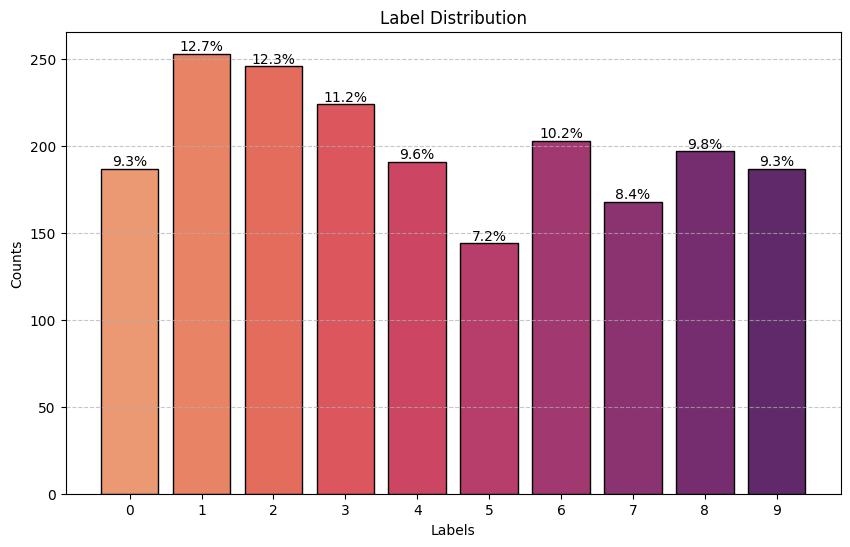

In [51]:
print("Visualization of Predicted Classifications")
print("*depending on model accuracy reported above, some labels/classifications will be incorrect.\n")
arr_predictions = np.array(predictions)
visualize_labels(arr_predictions)

# one-hot encode array of predictions in order to apply predicted labels to the visualized voxels
encoder = OneHotEncoder(sparse_output=False)
encoded_predictions = encoder.fit_transform(arr_predictions.reshape((-1, 1)))
visualize_voxels(X_test_tensor, encoded_predictions)

In [ ]:
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

# Load your data
file_path = '/mnt/data/drafting (1).ipynb'  # Update with your specific data file path if applicable
#data = pd.read_csv(file_path)  # Adjust loading based on file type
data = X_test

# Preprocessing: Standardize the data
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

# Apply PCA
pca = PCA()
data_pca = pca.fit_transform(data_scaled)

# Evaluate PCA
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Visualize Explained Variance
plt.figure(figsize=(10, 5))
plt.plot(cumulative_variance, marker='o', linestyle='--', color='b')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Explained Variance vs. Number of Components')
plt.grid()
plt.show()

# Visualize 2D Projection
plt.figure(figsize=(10, 7))
plt.scatter(data_pca[:, 0], data_pca[:, 1], c='blue', edgecolor='k', alpha=0.7)
plt.title('2D PCA Projection')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.show()

# Optional: Visualize Feature Contributions (Biplot-like)
loadings = pca.components_.T
plt.figure(figsize=(10, 7))
plt.scatter(data_pca[:, 0], data_pca[:, 1], alpha=0.5, label="Data points")
for i, feature in enumerate(data.columns):
    plt.arrow(0, 0, loadings[i, 0] * max(data_pca[:, 0]), loadings[i, 1] * max(data_pca[:, 1]),
              color='r', alpha=0.75)
    plt.text(loadings[i, 0] * max(data_pca[:, 0]) * 1.2, 
             loadings[i, 1] * max(data_pca[:, 1]) * 1.2, 
             feature, color='g', ha='center', va='center', fontsize=10)
plt.title('PCA Biplot')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid()
plt.legend()
plt.show()
